# Assignment 2: CO2 data imputation
We use the $CO_2$ data from Mauna Loa observatory in this assignment. We assume there is no observation from 1981 to 2000 and the goal is to estimate the missing part by Gaussian process. You will need to complete the empty part this notebook to achieve this goal.

## Prepare training and test data.
You don't have to complete any code in this section.

In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import cholesky, solve
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

data = pd.read_csv('CO2.csv', header=0, index_col=0, parse_dates=True)
# Add an x column such that CO2 = f(x) + noise
data['x'] = np.arange(0, len(data))
data.dropna(inplace=True)
data


,CO2,x
1958-03-15,315.71,2
1958-04-15,317.45,3
1958-05-15,317.51,4
1958-07-15,315.87,6
1958-08-15,314.93,7
...,...,...
2022-03-15,418.45,770
2022-04-15,420.02,771
2022-05-15,420.78,772
2022-06-15,420.68,773


Text(0, 0.5, 'CO2[ppm]')

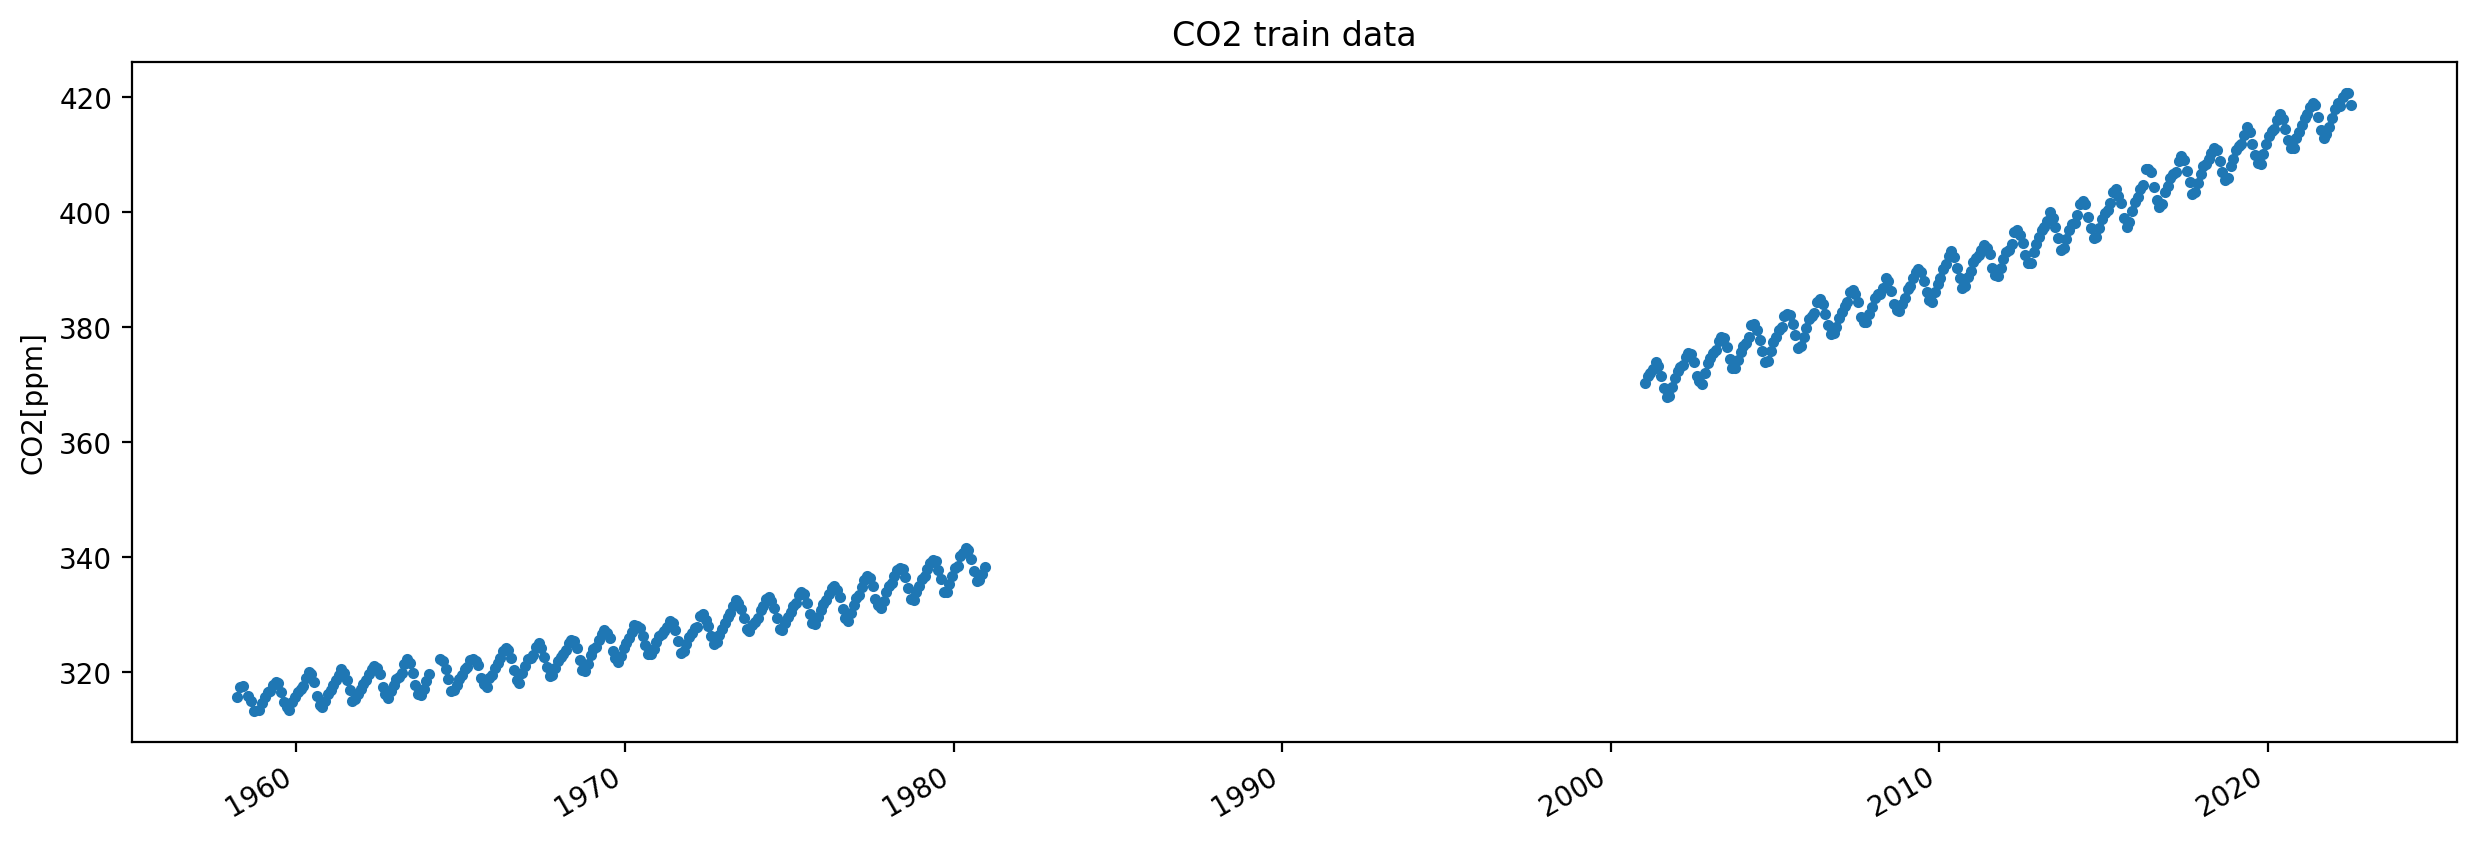

In [7]:
test_data = data.loc['1981':'2000', ['x', 'CO2']]  # We assume test data from 1981 to 2000 are unknown
train_data = data.loc[~data.index.isin(test_data.index), ['x', 'CO2']]  # We assume train data are known
train_data.CO2.plot(figsize=(15, 5), style='.', title="CO2 train data")
plt.ylabel('CO2[ppm]')

## Define Kernel functions

The code for `SE_kernel` and `white_noise_kernel` is given. **Please complete `periodic_kernel` and `linear_kernel`**.

In [2]:
def SE_kernel(x1, x2,  l2, s2=1):
    """Squared Exponential kernel
    ----------
    x1,x2: np.array, n by 1 input array
    l2: positive float, (length scale)^2
    s2: float, sigma^2
    """
    return s2*np.exp(-(x1.reshape([-1,1]) - x2.reshape([1,-1]))**2/l2)

def white_noise_kernel(x1, x2, e2=1):
    """White noise kernel
    ----------
    x1,x2: np.array, n by 1 input array
    e2: positive float, variance
    """
    if x1.shape == x2.shape:
        return e2*np.eye(x1.shape[0])
    else:
        raise ValueError("x1 and x2 should have the same shape")

def periodic_kernel(x1, x2, p, l2, s2=1):
    """Periodic kernel
    ----------
    x1,x2: np.array, n by 1 input array
    p: positive float, period
    l2: positive float, (length scale)^2
    s2: positive float, sigma^2
    """
    # Give your implementation here
    # calculate the distance between x1 and x2
    distance = np.abs(x1.reshape([-1,1]) - x2.reshape([1,-1]))
    # calculate the periodic kernel
    periodic_distance = np.pi * distance / p
    # calculate the sin term
    sin_term = np.sin(periodic_distance)
    # calculate the kernel value
    return s2 * np.exp(-2/l2 * sin_term**2)
    #  return s2*np.exp(-2/l2*np.sin(np.pi/p*np.abs(x1.reshape([-1,1]) - x2.reshape([1,-1])))**2)

def linear_kernel(x1, x2, c, s2=1):
    """Linear kernel (note we do not have a sigma_b^2 in this kernel)
    ----------
    x1,x2: np.array, n by 1 input array
    c: float, constant
    s2: float, sigma^2
    """
    # Give your implementation here
    # calculate the shifted value
    x1_shifted = x1.reshape([-1,1]) - c
    x2_shifted = x2.reshape([1,-1]) - c
    # calculate the kernel value
    return s2*(x1_shifted)*(x2_shifted) 
    # return s2*(x1.reshape([-1,1])-c)*(x2.reshape([1,-1])-c)


In [3]:
def log_marginal_likelihood(x, y, kernel, kernel_params, e2):
    """Log marginal likelihood
    ----------
    x: np.array, n by 1 input array
    y: np.array, n by 1 output array
    kernel: function, kernel function
    kernel_params: np.array, kernel parameters
    e2: float, noise variance
    """
    K = kernel(x, x, kernel_params) + white_noise_kernel(x, x, e2)
    # Give your implementation here, you should use cholesky decomposition to improve speed.
    L = cholesky(K)
    alpha = solve(L.T, solve(L, y))
    lml = -0.5 * y.T.dot(alpha) - np.sum(np.log(np.diag(L))) - x.shape[0] / 2 * np.log(2 * np.pi)
    return lml


def prediction(X, y, X_star, kernel, kernel_params, e2):
    """Prediction
    ----------
    X: np.array, n by 1 input array at observed points
    y: np.array, n by 1 output array at observed points
    X_star: np.array, m by 1 input array at unknown points
    kernel: function, kernel function
    kernel_params: np.array, kernel parameters
    e2: float, noise variance
    
    return:
    -------
    mean: np.array, m by 1 mean of the predictive distribution
    covariances: np.array, m by m covariance matrix of the predictive distribution
    """
    K = kernel(X, X, kernel_params) + white_noise_kernel(X, X, e2)
    # Give your implementation here
    K_star = kernel(X_star, X, kernel_params)
    K_star_star = kernel(X_star, X_star, kernel_params)
    L = cholesky(K)
    alpha = solve(L.T, solve(L, y))
    v = solve(L, K_star.T)
    mean = K_star.dot(alpha)
    covariances = K_star_star - v.T.dot(v)
    return mean, covariances

## Using SE_kernel + noise
We first try to model the long range trend in CO2 by an SE kernel. You can see the results of using SE kernel after implementing the `log_marginal_likelihood` and `prediction` You don't have to complete any code in this section. 

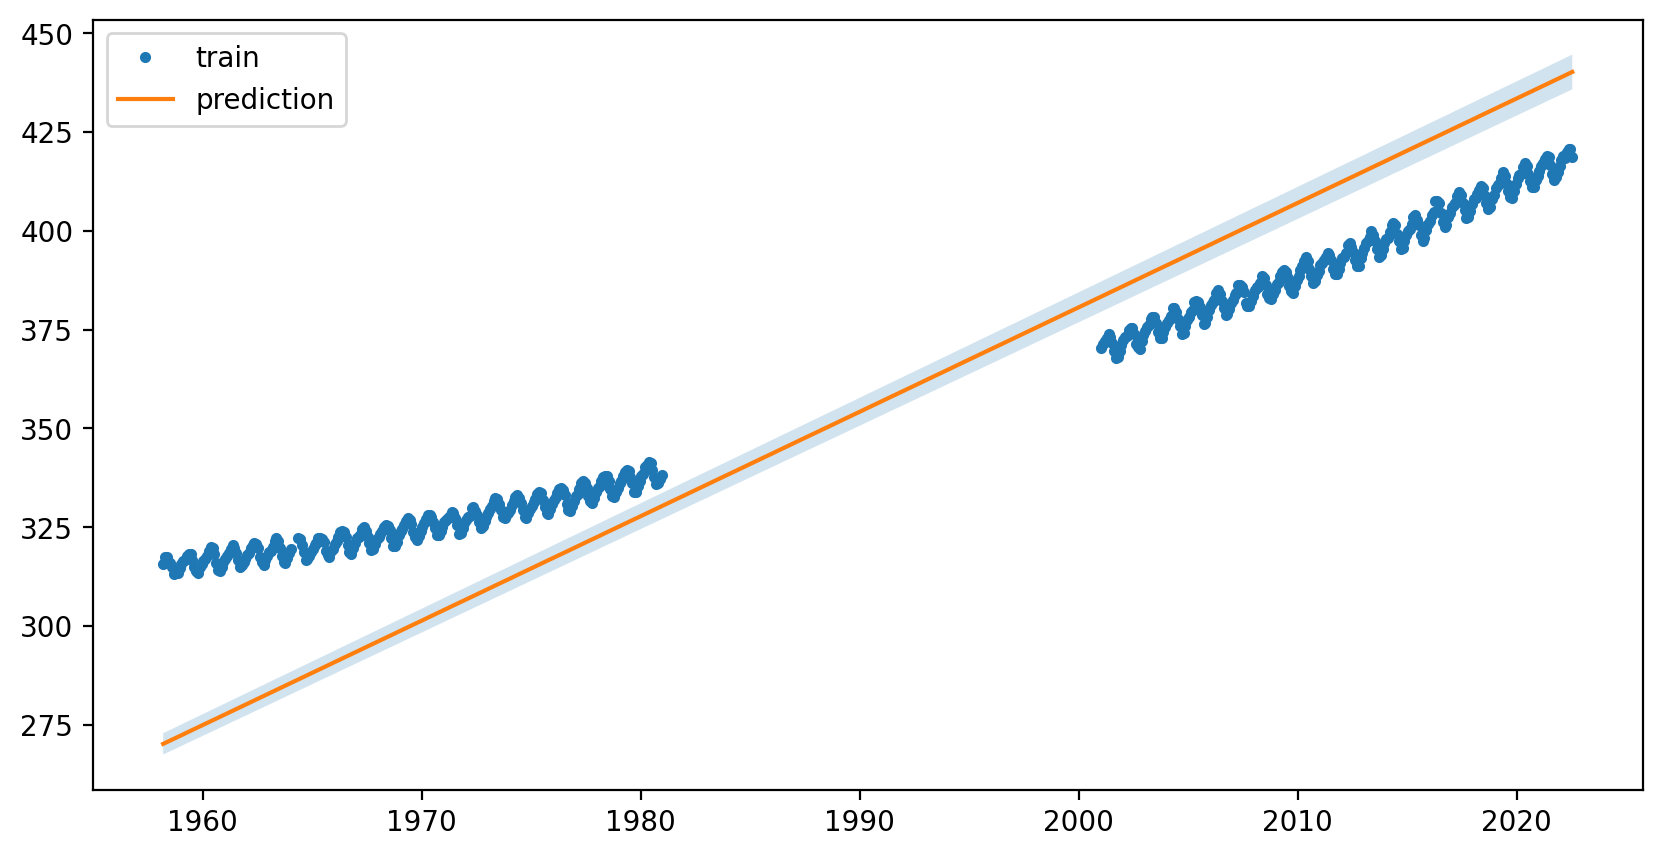

In [8]:
# Please give initial values for the kernel parameters
SE_l2_init = (12*10)**2  # The initial guess length scale of the SE kernel is 10 years (10*12 months)
SE_s2_init = 20
e2_init = 10

# linear kernel initial parameters
c_init = 0      # constant
s2_init = 1     # variance
e2_init = 10    # noise variance

def kernel1(x1, x2, kernel_params):
    """Wrap the kernel function for optimization. Linear kernel."""
    LK_c = kernel_params[0]    # constant 
    LK_s2 = kernel_params[1]   # variance 
    return linear_kernel(x1, x2, c=LK_c, s2=LK_s2)

# Please minimize the negative log likelihood to optimize the kernel parameters
def NLL(params):
    """Negative log likelihood
    ----------
    params: np.array, kernel parameters
    args: tuple, (x, y, kernel, e2)
    """
    kernel_params = params[:-1]
    e2 = params[-1]
    return -log_marginal_likelihood(train_data.x.values, train_data.CO2.values, kernel1, kernel_params, e2)

# Use scipy minimize to optimize the negative log likelihood. 
res = minimize(NLL,
               x0=np.array([c_init, s2_init, e2_init]),  # initial values
               method='L-BFGS-B',
               bounds=((None, None), (1e-5, None), (0.1, None)))  # bounds for the parameters

# print("optimized parameters:")
# print(f"c (constant): {res.x[0]:.4f}")
# print(f"s2 (variance): {res.x[1]:.4f}")
# print(f"e2 (noise variance): {res.x[2]:.4f}")
# print(f"negative log likelihood: {res.fun:.4f}")

# Make predictions
y, var = prediction(train_data.x.values, train_data.CO2.values, data.x.values, kernel1, res.x[:-1], res.x[-1])
data['y'] = y
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(train_data.CO2, '.',label='train')
ax.plot(data.y, label='prediction')
ax.fill_between(data.index, data.y-2*np.sqrt(np.diag(var)),
                data.y+2*np.sqrt(np.diag(var)), alpha=0.2)
plt.legend()


# Use Linear_kernel + noise
Similar to the previous section, **please use linear_kernel + noise to estimate the CO2. Plot the confidence interval of $\pm 2\sigma$**.
Some suggestion for initial hyperparameters: `c = 0`, `s2 = 1`. Note that `c` is unbounded. 

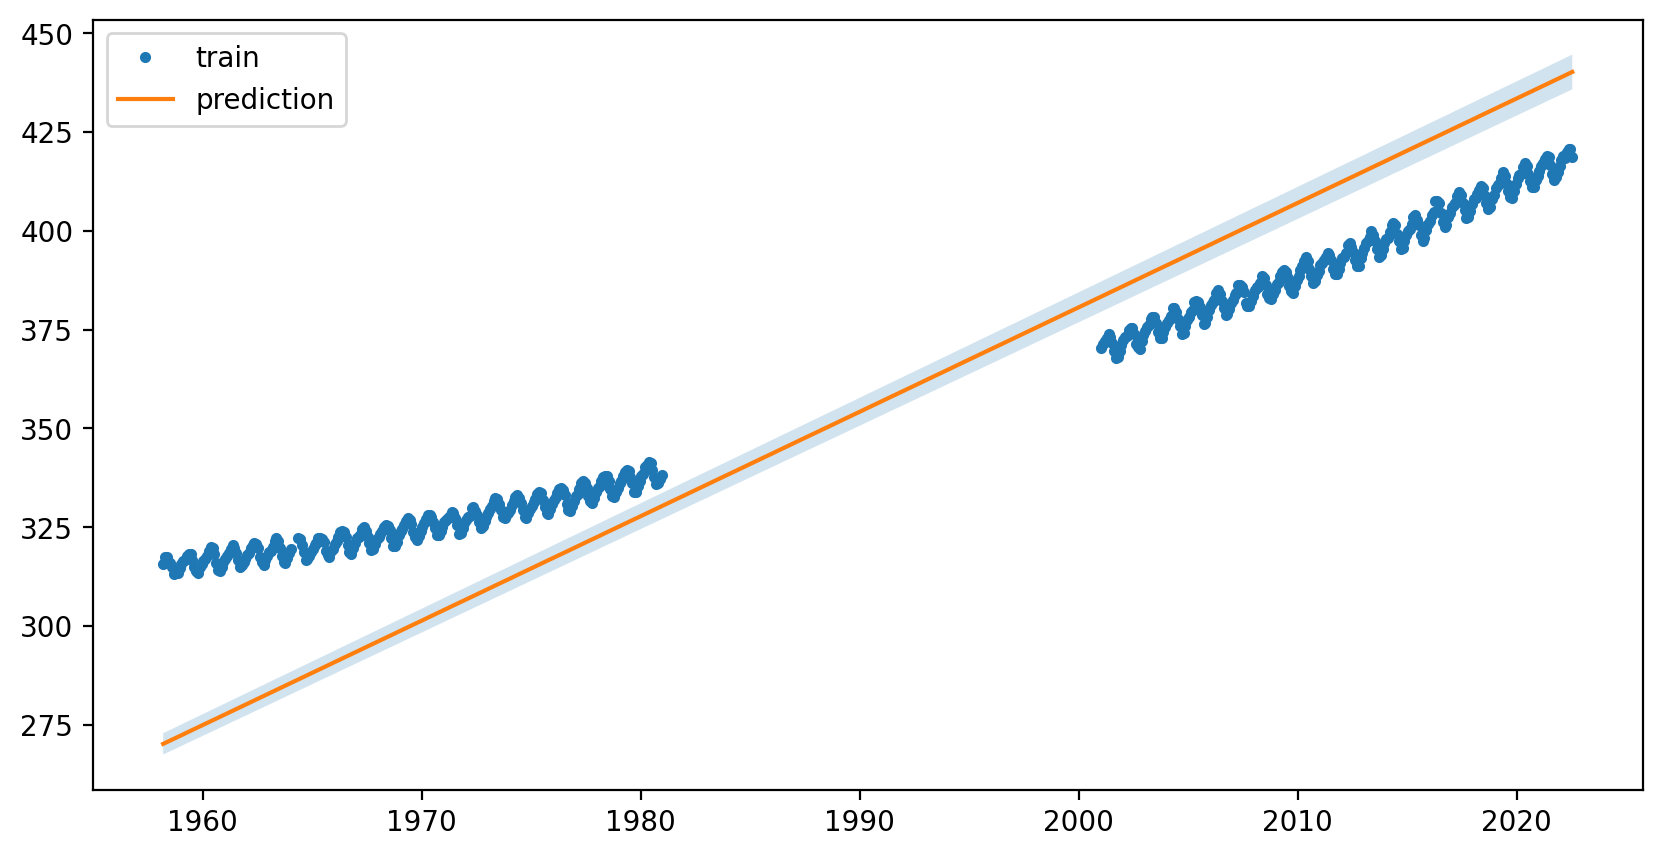

In [9]:
# Please give initial values for the kernel parameters
SE_l2_init = (12*10)**2  # The initial guess length scale of the SE kernel is 10 years (10*12 months)
SE_s2_init = 20
e2_init = 10

# linear kernel initial parameters
c_init = 0      # constant
s2_init = 1     # variance
e2_init = 10    # noise variance

def kernel1(x1, x2, kernel_params):
    """Wrap the kernel function for optimization. Linear kernel."""
    LK_c = kernel_params[0]    # constant 
    LK_s2 = kernel_params[1]   # variance 
    return linear_kernel(x1, x2, c=LK_c, s2=LK_s2)

# Please minimize the negative log likelihood to optimize the kernel parameters
def NLL(params):
    """Negative log likelihood
    ----------
    params: np.array, kernel parameters
    args: tuple, (x, y, kernel, e2)
    """
    kernel_params = params[:-1]
    e2 = params[-1]
    return -log_marginal_likelihood(train_data.x.values, train_data.CO2.values, kernel1, kernel_params, e2)

# Use scipy minimize to optimize the negative log likelihood. 
res = minimize(NLL,
               x0=np.array([c_init, s2_init, e2_init]),  # initial values
               method='L-BFGS-B',
               bounds=((None, None), (1e-5, None), (0.1, None)))  # bounds for the parameters

# print("optimized parameters:")
# print(f"c (constant): {res.x[0]:.4f}")
# print(f"s2 (variance): {res.x[1]:.4f}")
# print(f"e2 (noise variance): {res.x[2]:.4f}")
# print(f"negative log likelihood: {res.fun:.4f}")

# Make predictions
y, var = prediction(train_data.x.values, train_data.CO2.values, data.x.values, kernel1, res.x[:-1], res.x[-1])
data['y'] = y
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(train_data.CO2, '.',label='train')
ax.plot(data.y, label='prediction')
ax.fill_between(data.index, data.y-2*np.sqrt(np.diag(var)),
                data.y+2*np.sqrt(np.diag(var)), alpha=0.2)
plt.legend()


# Use periodic_kernel + noise
Similar to the previous section, **please use periodic_kernel + noise to estimate the CO2. Plot the confidence interval of $\pm 2\sigma$**.
Some suggestion for initial hyperparameters:
- We can set `p=12` to reduce the number of hyperparameters that need to be optimized.

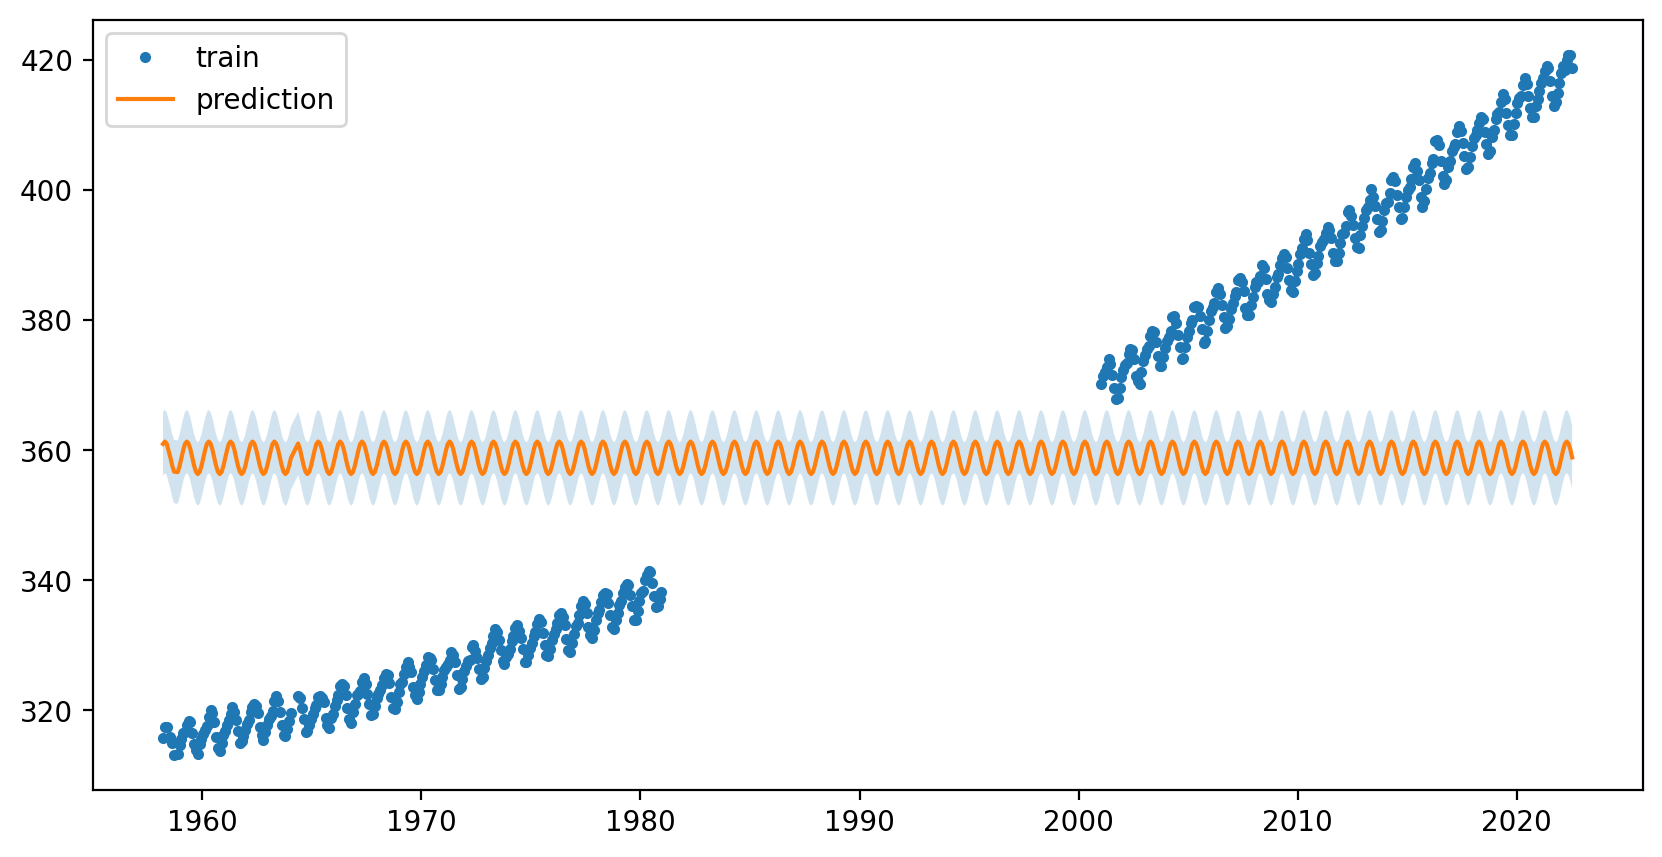

In [7]:
# Please give initial values for the kernel parameters
PK_p0=12
s2_init=1
l2_init = (1)**2  
e2_init = 10


def kernel2(x1, x2, kernel_params):
    """Wrap the kernel function for optimization. Periodic kernel."""
    # please give your implementation here for the periodic kernel
    PK_l2 = kernel_params[0]
    PK_s2 = kernel_params[1]
    return periodic_kernel(x1, x2, p=PK_p0, l2=PK_l2, s2=PK_s2)


# Please minimize the negative log likelihood to optimize the kernel parameters
def NLL_periodic(params):
    """
    Negative log likelihood for periodic kernel
    params: np.array, kernel parameters
    args: tuple, (x, y, kernel, e2)
    """
    kernel_params = params[:-1]
    e2 = params[-1]
    return -log_marginal_likelihood(train_data.x.values, train_data.CO2.values, kernel2, kernel_params, e2)

# optimize the kernel parameters
res = minimize(NLL_periodic,
               x0=np.array([l2_init, s2_init, e2_init]),  # initial values
               method='L-BFGS-B',
               bounds=((1e-5, None), (1e-5, None), (0.1, None)))  # bounds for the parameters
# print("optimized parameters:")
# print(f"period p: {PK_p0} (fixed)")
# print(f"length scale square l2: {res.x[0]:.4f}")
# print(f"variance parameter s2: {res.x[1]:.4f}")
# print(f"noise variance e2: {res.x[2]:.4f}")
# print(f"negative log likelihood: {res.fun:.4f}")

# Make predictions
y, var = prediction(train_data.x.values, train_data.CO2.values, data.x.values, kernel2, res.x[:-1], res.x[-1])
data['y'] = y
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(train_data.CO2, '.',label='train')
ax.plot(data.y, label='prediction')
ax.fill_between(data.index, data.y-2*np.sqrt(np.diag(var)),
                data.y+2*np.sqrt(np.diag(var)), alpha=0.2)
plt.legend()

# # result analysis
# print(f"\nresult analysis:")
# print(f"number of training data points: {len(train_data)}")
# print(f"number of prediction data points: {len(data)}")
# print(f"prediction mean range: [{np.min(y):.2f}, {np.max(y):.2f}] ppm")
# print(f"prediction standard deviation range: [{np.min(np.sqrt(np.diag(var))):.2f}, {np.max(np.sqrt(np.diag(var))):.2f}] ppm")

# Use linear_kernel + periodic_kernel + SE_kernel + noise
Similar to the previous section, **please use linear_kernel + periodic_kernel + SE_kernel + noise to estimate the CO2. Plot the confidence interval of $\pm 2\sigma$**.

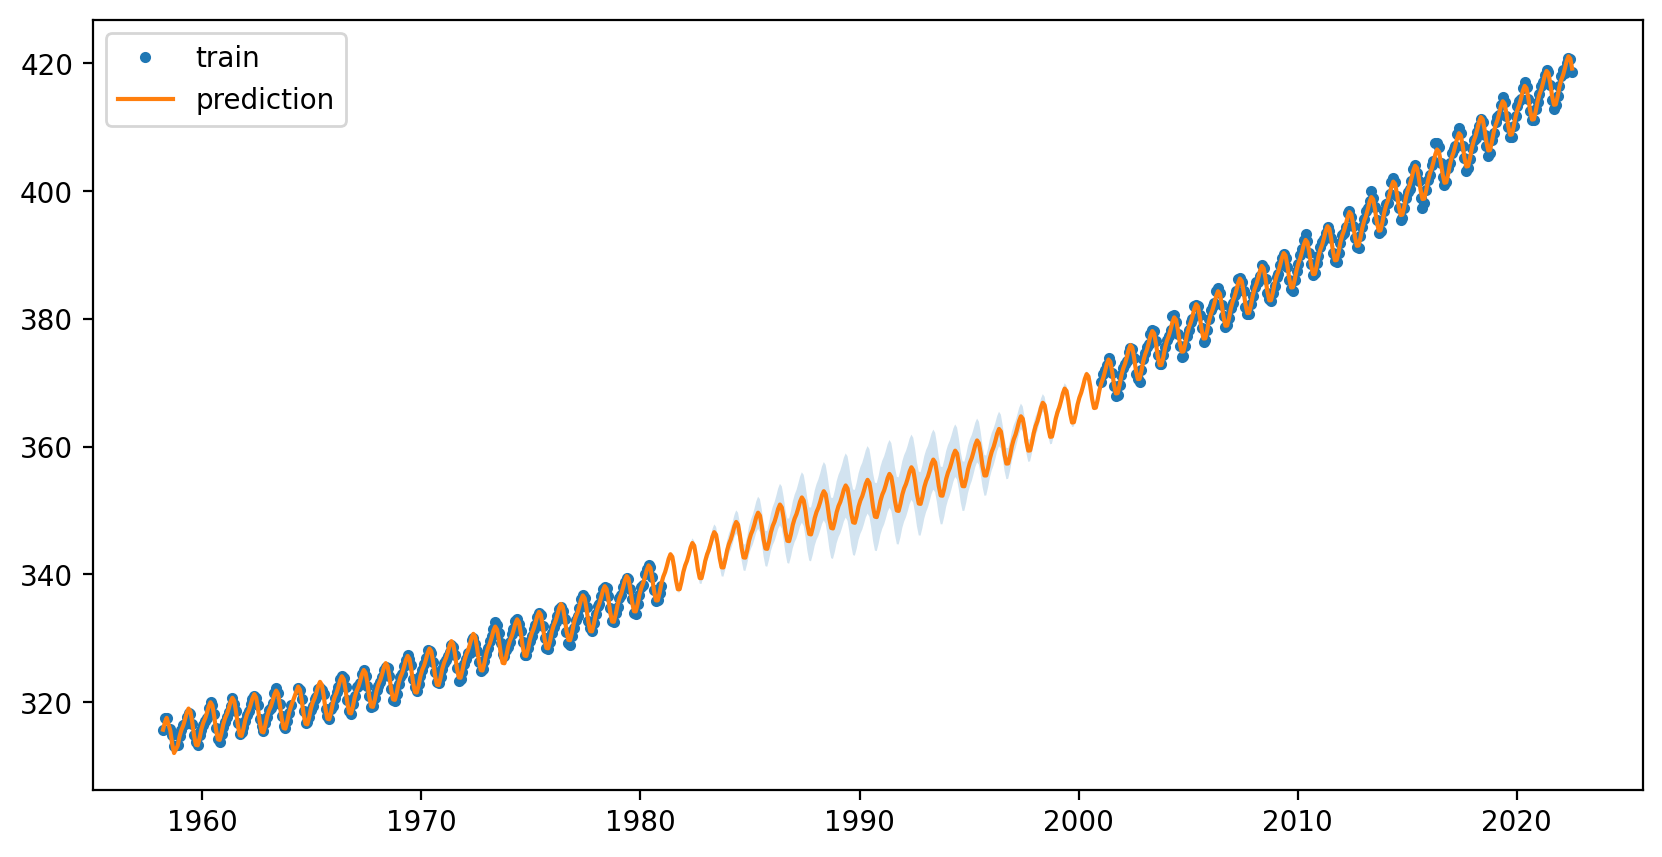

In [8]:
# Please give initial values for the kernel parameters
PK_p0 = 12                   
SE_l2_init = (12*10)**2     
SE_s2_init = 20            
PK_l2_init = 10              
PK_s2_init = 50             
LK_c_init = 0               
LK_s2_init = 1             
e2_init = 10              

def kernel3(x1, x2, kernel_params):
    """Wrap the kernel function for optimization. SE + Periodic + linear kernel."""
    # please give your implementation here for the SE + Periodic + linear kernel
    LK_c = kernel_params[0]   # linear kernel constant
    LK_s2 = kernel_params[1]  # linear kernel variance
    PK_l2 = kernel_params[2]  # periodic kernel length scale square
    PK_s2 = kernel_params[3]  # periodic kernel variance
    SE_l2 = kernel_params[4]  # SE kernel length scale square
    SE_s2 = kernel_params[5]  # SE kernel variance

    # Combined kernel functions 
    K_SE = SE_kernel(x1, x2, l2=SE_l2, s2=SE_s2)
    K_periodic = periodic_kernel(x1, x2, p=PK_p0, l2=PK_l2, s2=PK_s2)
    K_linear = linear_kernel(x1, x2, c=LK_c, s2=LK_s2)
    
    return K_SE + K_periodic + K_linear

# Please minimize the negative log likelihood to optimize the kernel parameters
def NLL_combined(params):
    """Negative log likelihood for combined kernels"""
    kernel_params = params[:-1]
    e2 = params[-1]
    return -log_marginal_likelihood(train_data.x.values, train_data.CO2.values, kernel3, kernel_params, e2)

# Parameter bounds setting 
bounds_combined = (
    (None, None),    # LK_c (unbounded)
    (1e-5, None),    # LK_s2
    (1e-5, None),    # PK_l2
    (1e-5, None),    # PK_s2
    (1e-5, None),    # SE_l2
    (1e-5, None),    # SE_s2
    (0.1, None)      # e2
)

# Optimize the kernel parameters
res = minimize(NLL_combined, 
               x0=np.array([LK_c_init, LK_s2_init, PK_l2_init, PK_s2_init, 
                           SE_l2_init, SE_s2_init, e2_init]), 
               method='L-BFGS-B',
               bounds=bounds_combined)

# print("optimized parameters:")
# print(f"linear kernel - constant: {res.x[0]:.4f}")
# print(f"linear kernel - variance: {res.x[1]:.4f}")
# print(f"periodic kernel - length scale square: {res.x[2]:.4f}")
# print(f"periodic kernel - variance: {res.x[3]:.4f}")
# print(f"SE kernel - length scale square: {res.x[4]:.4f}")
# print(f"SE kernel - variance: {res.x[5]:.4f}")
# print(f"noise variance: {res.x[6]:.4f}")
# print(f"negative log likelihood: {res.fun:.4f}")

# Make predictions
y, var = prediction(train_data.x.values, train_data.CO2.values,
                    data.x.values, kernel3, res.x[:-1], res.x[-1])
data['y'] = y
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_data.CO2, '.', label='train')
ax.plot(data.y, label='prediction')
ax.fill_between(data.index, data.y-2*np.sqrt(np.diag(var)),
                data.y+2*np.sqrt(np.diag(var)), alpha=0.2)
plt.legend()

